# Regularization, cross validation and overfitting

### This notebook contains some illustrative examples to go along with the Regularization unit. There is a lot of code, most of which can be safely ignored. Focus on these take-home ideas
- A model might fit training data very well while missing the underlying trend
- Scikit-learn provides access to regression with l2 regularization via linear_model.Ridge() and l1 regression via linear_model.Lasso(). The two combined can be accessed with linear_model.ElasticNet(), which maintains some of the advantages of both.
- We can add an l1 or l2 penalty to a LogisticRegression by adding penalty='l2' when creating the model, and passing in an optional parameter C, where C=1/$\alpha$. For eg: model = linear_model.LogisticRegression(C=C, penalty='l1', tol=0.01) 
- An l1 penalty can help reduce the number of parameters on which a model relies - often a good way to combat overfitting.
- Cross validation can be useful for tuning models. We see how using cross-validation can help us select parameters such as $\alpha$, and demonstrate the use of model_selection.GridSearchCV() to try different combinations of parameters and select the best.


# Section 1 - Demonstrating overfitting

We've looked at this before, but here's yet another example showing overfitting in a regression problem. This is a small, contrived example. The code here is to illustrate a point - don't feel the need to do more than glance over it.

In [1]:
import random

from sklearn import datasets
from sklearn import linear_model
from sklearn import model_selection

from sklearn.metrics import mean_squared_error

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# This bit of code silences some warnings generatd by the Logistic Regression code.
# Scikit are changing the default solver - you can leave this out and specify the solver: LogisticRegression(solver='liblinear')
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%matplotlib inline
# Add some plotting config
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
# Set a random seed, for consistency
random.seed(300)

### Generating Data

In [4]:
x = np.linspace(0, 9, 10) 
y_star = 2 + 8*x + -0.42*(x**2) # The true function
e = np.random.randn(len(x)) * 8 # Some errors/noise
y = y_star + e # y now simulates noisy data

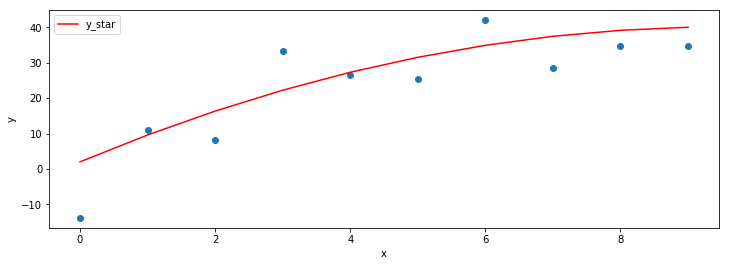

In [5]:
# Plotting our generated data and the true, underlying trend
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(x, y)
ax.plot(x, y_star, 'r', label='y_star')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

plt.show()

### Linear Model

Now, let's try to fit a linear model and a quadratic model, and see how well they score

In [6]:
x = x.reshape(-1, 1) # Into the format we need for scikit models
X = x
lin = linear_model.LinearRegression() # Create the model
lin.fit(X, y) # Train the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

We can use the estimated model parameters to plot the predictions and to find the MSE

In [7]:
yhat_lin = lin.intercept_ + lin.coef_ * x # The model prediction

In [8]:
print('mean squared error = {:.2f}'.format(mean_squared_error(y, yhat_lin)))

mean squared error = 89.31


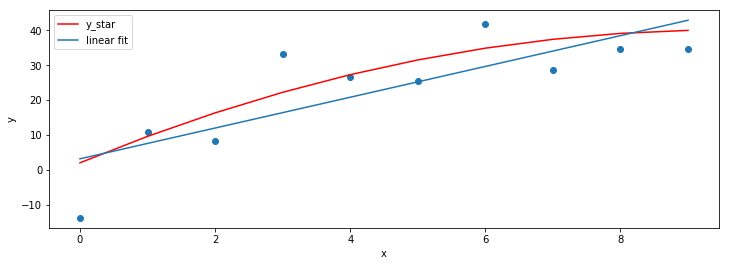

In [9]:
# Plotting
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x.reshape(-1, 1), y)
ax.plot(x, y_star, 'r', label='y_star')
ax.plot(x, yhat_lin, label='linear fit')

ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

plt.show()

The linear model does a fairly good job describing the data.

### Quadratic Model

mean squared error = 40.35


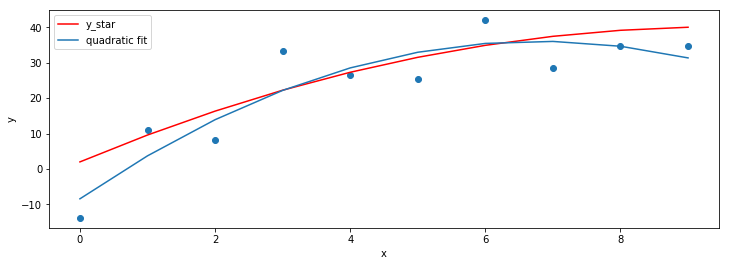

In [10]:
X = np.hstack([x, x**2]) # Adding an x^2 term

quad = linear_model.LinearRegression()
quad.fit(X, y) #Training the model
yhat_quad = quad.intercept_ + quad.coef_[0] * X[:, 0] + quad.coef_[1] * X[:, 1] # The quadratic model's predictions
print('mean squared error = {:.2f}'.format(mean_squared_error(y, yhat_quad)))

# Plotting...
fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x.reshape(-1, 1), y)
ax.plot(x, y_star, 'r', label='y_star')
ax.plot(x, yhat_quad, label='quadratic fit')

ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

plt.show()

Look at the MSE - the quadratic model does better than the linear model, as expected. It has succeeded in capturing the underlying trend.

### High order polynomial

In [12]:
x = x.reshape(-1, 1)
X = x
degree = 10
for k in range(2, degree + 1):
    X = np.hstack([X, pow(x, k)])
    
poly = linear_model.LinearRegression()
poly.fit(X, y)
print('mean squared error = {:.2f}'.format(mean_squared_error(y, poly.predict(X))))



mean squared error = 0.00


When we look at the MSE, it appears that this model does best of all. But when we plot it, we see a slightly different story:

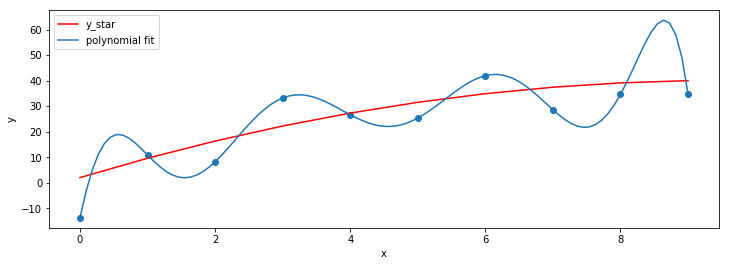

In [13]:
# Make a new set of X, regularly increasing, to plot the prediction in more detail
xn = np.linspace(0, 9, 100).reshape(-1, 1)
X = xn
degree = 10
for k in range(2, degree + 1):
    X = np.hstack([X, pow(xn, k)])
yhat_poly = poly.predict(X)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x.reshape(-1, 1), y)
ax.plot(x, y_star, 'r', label='y_star')
ax.plot(xn, yhat_poly, label='polynomial fit')

ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

plt.show()


Now we'll use the same underlying process as before to simulate some new readings. This is equivalent to seeing new data. We'll see how each of the three models do in this case:

In [14]:
# The new, noisy data
x2 = np.linspace(0, 9, 30) 
y_star2 = 2 + 8*x2 + -0.42*(x2**2) # The true function
e2 = np.random.randn(len(x2)) * 8 # Some errors/noise
y2 = y_star2 + e2 # y now simulates noisy data

# The new test data (model inputs)
X1 = x2.reshape(-1, 1)
X2 = np.hstack([X1, X1**2])
X3 = X1
for k in range(2, degree + 1):
    X3 = np.hstack([X3, pow(X1, k)])

# Testing with this new, unseen data
print('Linear model mean squared error = {:.2f}'.format(mean_squared_error(y2, lin.predict(X1))))
print('Quadratic model mean squared error = {:.2f}'.format(mean_squared_error(y2, quad.predict(X2))))
print('10th order Polynomial mean squared error = {:.2f}'.format(mean_squared_error(y2, poly.predict(X3))))

Linear model mean squared error = 78.39
Quadratic model mean squared error = 79.34
10th order Polynomial mean squared error = 189.57


As you can see, the MSE for the high order model is now the highest of all three errors - it does not generalize well.

In [ ]:
# Plotting the polynomial function as before, but this time showing the new data.
# The underlying trend is the same, but the model is not accurate
xn = np.linspace(0, 9, 100).reshape(-1, 1)
X = xn
degree = 10
for k in range(2, degree + 1):
    X = np.hstack([X, pow(xn, k)])
yhat_poly = poly.predict(X)

fig = plt.figure()

ax = fig.add_subplot(111)

ax.scatter(x.reshape(-1, 1), y, label='training data')
ax.scatter(x2.reshape(-1, 1), y2, label='unseen data')

ax.plot(x, y_star, 'r', label='underlying trend')
ax.plot(xn, yhat_poly, label='polynomial fit')

ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()

plt.show()

#### Take-home idea: complex models with sparse training data are more prone to overfitting.

# Section 2 - Regularization

Now on to regularization. We'll show examples of each of the three types of regularization mentioned in the notes.

## Example 1: l2 regularization and reducing coefficients

We use scikit-learn's ridge regression to demonstrate L2 regularization. Note: This is adapted from a [scikit-learn example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html) (BSD 3-Clause License).

We generate training data randomly, and study the effect of $\alpha$, the strength of regularization, on the model coefficients (parameters). Note: You may see $\lambda$ used instead of $\alpha$ when talking about this regularization parameter.

In [ ]:
# Making the random data
X, y, _ = datasets.make_regression(n_samples=10, n_features=10, coef=True,
                          random_state=42, bias=3.5)

In [ ]:
# We'll generate models with different alpha values, and compare the coefficient weights as alpha increases
coefs = [] # Coefficients
mses = [] # Errors

n_alphas = 100 
alphas = np.logspace(-4, 4, n_alphas)

# For each alpha value, fit a model and store the parameters
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    mses.append(mean_squared_error(ridge.predict(X), y))

In [ ]:
# Plotting how the model coefficients and error change as alpha is increased:

fig = plt.figure(figsize=(12, 8))
# plt.gca().set_adjustable("box")

ax = fig.add_subplot(211)
ax.plot(alphas, coefs)

ax.set_xscale('log')
ax.set_xlabel('')
ax.set_ylabel('coefficients')

plt.axis('tight')
plt.title('model coefficients vs strength of regularization')

ax = fig.add_subplot(212)
ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('')
ax.set_ylabel('mean-squared-error')


plt.axis('tight')
plt.title('model error vs strength of regularization')

plt.show()

As you can see, with higher alpha values, the coefficients are all driven to 0 and the error grows. The extreme case is undesirable, but as we'll see with real examples later on, reducing some weights is useful.

#### Take-home idea: l2 regularization shrinks the model coefficients.

## Example 2: l1 regularization

Here we want to illustrate how introducing an l1 penalty produces sparser classifiers - that is, classifiers that have zero weights for more of the inputs, focusing on a smaller number of critical inputs. 

For a change, instead of linear regression, here we use logistic regression to demonstrate L1 regularization and compare it with l2 regularization. Note: This is adapted from a [scikit-learn example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_l1_l2_sparsity.html) (BSD 3-Clause License).

We use logistic regression to classify images of two different digits.

In [ ]:
# Load the data from one of scikit's built in datasets
digits = datasets.load_digits()

In [ ]:
# Prepare the data
X, y = digits.data, digits.target

# We'll try to distinguish between these two digits (a binary classification problem)
d1 = 3
d2 = 6

# Using only those two digits
X = X[np.where(np.logical_or(y == d1, y == d2))]
y = y[np.where(np.logical_or(y == d1, y == d2))]

print(X.shape)
print(y.shape)

In [ ]:
# Show some examples from each of the two classes. Can you correctly identify all of them visually?

N = X.shape[0]
rand = [int(r) for r in np.random.rand(8) * N]

fig = plt.figure(figsize=(16, 8))

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(X[rand[i], :].reshape(8, 8), cmap='gray')
    ax.set_title(y[rand[i]])
    plt.axis('tight')

plt.show()

In [ ]:
y = (y == d2).astype(np.int) # 0 for d1, 1 for d2 (as required for LogisticRegression)

The strength of regularization here is controlled by the parameter C, which acts as the inverse of $\lambda$, i.e., lower values of C imply higher regularization. 

In [ ]:
plt.figure(figsize=(12, 8))
           
for i, C in enumerate([100, 1, 0.01]):
    
    log_l1 = linear_model.LogisticRegression(C=C, penalty='l1', tol=0.01)
    log_l2 = linear_model.LogisticRegression(C=C, penalty='l2', tol=0.01)
    
    log_l1.fit(X, y)
    log_l2.fit(X, y)
    
    coef_l1 = log_l1.coef_.ravel()
    coef_l2 = log_l2.coef_.ravel()
    
    sparsity_l1 = np.mean(coef_l1 == 0)
    sparsity_l2 = np.mean(coef_l2 == 0)
    
    print("C = {:.2f}".format(C))
    print("L1 score: {:.2f}".format(log_l1.score(X, y)))
    print("L2 score: {:.2f}".format(log_l2.score(X, y)))
    print("L1 sparsity: {:.2f}".format(sparsity_l1))
    print("L2 sparsity: {:.2f}".format(sparsity_l2))
    print('')
    
    l1plt = plt.subplot(2, 3, i+1)
    l2plt = plt.subplot(2, 3, i+4)
    if i == 0:
        l1plt.set_title("l1 regularization")
        l2plt.set_title("l2 regularization")
    
    l1plt.imshow(np.abs(coef_l1.reshape(8, 8)), interpolation='nearest',
                 cmap='jet', vmin=0, vmax=1)
    plt.axis('tight')
    l2plt.imshow(np.abs(coef_l2.reshape(8, 8)), interpolation='nearest',
                 cmap='jet', vmin=0, vmax=1)
    plt.axis('tight')
    
    plt.text(2, -3, "C = {:.1e}".format(C))


Both L2 and L1 regularized logistic classifiers yield high classification accuracies (~100%). But L1-penalized classifiers are far sparser than L2-penalized classifiers, i.e., they perform equally well but with fewer weights having non-zero values (as can be seen in the plot above). Further, the sparsity of the L1 models increases with the strength of regularization (towards the right of the plot).

## Example 3: l2 & l1 regularization with Elastic Net

Finally we combine both types of regularization using scikit-learn's Elastic Net. Note: This is adapted from a [scikit-learn example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_and_elasticnet.html) (BSD 3-Clause License).

We generate random X with a small number of samples (N) and a large number of dimensions (d). Using a random but sparse coefficient vector w, we generate y, and then try to recover w using regression models. Since y is only determined by the coefficients in w, any weights attached to other coefficients are due to noise in the data and are undesirable.

In [ ]:
np.random.seed(42)

N, d = 100, 200

X = np.random.randn(N, d)

w = np.random.normal(scale=3, size=d)
inds = np.arange(d)
np.random.shuffle(inds)
w[inds[10:]] = 0 # make sparse

y = np.dot(X, w)
y += 0.01 * np.random.randn()

In [ ]:
ratio = 0.3
n = int(ratio * N)

X_train, y_train = X[:n], y[:n]
X_test, y_test = X[n:], y[n:]

In [ ]:
# A model with just l1 regularization using linear_model.Lasso
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

In [ ]:
print('L1 score: {:.2f}'.format(lasso.score(X_test, y_test)))

In [ ]:
# Now the ElasticNet model that combines the two
elastic = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.7)
elastic.fit(X_train, y_train)

In [ ]:
print('Elastic net score: {:.2f}'.format(elastic.score(X_test, y_test)))

In [ ]:
fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(311)
ax.plot(w)

plt.axis('tight')
plt.title('underlying coefficients w')

ax = fig.add_subplot(312)
ax.plot(lasso.coef_)

plt.axis('tight')
plt.title('lasso model (l1 regularization) coefficients')

ax = fig.add_subplot(313)
ax.plot(elastic.coef_)

plt.axis('tight')
plt.title('elastic net (l1 & l2 regularization) coefficients')

plt.show()

The Lasso model (L1 regularization) fares better than Elastic Net (L2 & L1 regularization) in this case, as it manages to identify the sparse weights correctly. Elastic Net yields a less sparse coefficient vector in comparison.

## Case Study: predicting car mpg (miles per gallon)

In [ ]:
import pandas as pd

In [ ]:
fn = 'auto-mpg.txt'
cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'year', 'origin', 'name']

In [ ]:
cars = pd.read_csv(fn, names=cols, delim_whitespace=True, index_col=False)

In [ ]:
cars.head()

In [ ]:
cars = cars[cars.horsepower != '?']
cars['horsepower'] = pd.to_numeric(cars['horsepower'])

In [ ]:
cars.describe()

We've seen this dataset before. You may want to plot some scatter plots and explore it a bit, but for now let's start trying to predict the mpg. Before we split the data, we'll add a few extra columns with polynomial terms

In [ ]:
cars['displacement-sq'] = cars['displacement'] ** 2
cars['horsepower-sq'] = cars['horsepower'] ** 2
cars['weight-sq'] = cars['weight'] ** 2
cars.head() # Note our three new columns

In [ ]:
Xcols = ['year', 'origin', 'cylinders', 'displacement', 'displacement-sq', 'horsepower', 'horsepower-sq', 
         'weight', 'weight-sq', 'acceleration', ]# The columns that will be inputs
ycol = ['mpg'] # What we're trying to predict

X = cars[Xcols]
y = cars[ycol]

test_ratio = 0.2

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_ratio, random_state=42)

At this stage, we can start trying different models.

### Linear model

As a baseline, we build a linear model with no regularization. We'll see how well later models compare to this.

In [ ]:
mLR = linear_model.LinearRegression()
mLR.fit(X_train, y_train)
print('model R^2 on training dataset: {:.4f}'.format(mLR.score(X_train, y_train)))
print('model R^2 on test dataset:     {:.4f}'.format(mLR.score(X_test, y_test)))

We can examine the parameters:

In [ ]:
for x, w in zip(Xcols, mLR.coef_.ravel()):
    print('{: .4f}: {}'.format(w, x))

Test R^2 is lower than training R^2, but not by a huge margin - we're likely not overfitting here.

## ridge regression (l2)

In [ ]:
mR = linear_model.Ridge()

In [ ]:
mR.fit(X_train, y_train)

In [ ]:
for x, w in zip(Xcols, mR.coef_.ravel()):
    print('{: .4f}: {}'.format(w, x))

In [ ]:
print('model R^2 on training dataset: {:.4f}'.format(mR.score(X_train, y_train)))
print('model R^2 on test dataset:     {:.4f}'.format(mR.score(X_test, y_test)))

The L2 regularized model yields a very similar model to the plain linear model, indicating that there was not much overfitting with the linear model.

## lasso model (l1)

In [ ]:
mL = linear_model.Lasso(tol=0.01)

In [ ]:
mL.fit(X_train, y_train)

In [ ]:
for x, w in zip(Xcols, mL.coef_):
    print('{: .4f}: {}'.format(w, x))

In [ ]:
print('model R^2 on training dataset: {:.4f}'.format(mL.score(X_train, y_train)))
print('model R^2 on test dataset:     {:.4f}'.format(mL.score(X_test, y_test)))

The L1 model, as expected, is sparser. Notice that only four inputs are assigned any weight. And yet it's performance on the test dataset matches or slightly exceeds that of the other two models - it is more generalizable. 

Increasing the test ratio to 0.95 (so only training with 5% of the data) the results are more dramatic. Linear regression scores 0.98 on the training data but only 0.5 on the test data - it has overfit thanks to the small sample size. Ridge (l2) regression fares slightly better, scoring 0.98 on the training data and 0.6 on the test data. And Lasso (l1) regression yields a sparse classifier that scores worse on the training data (0.93) but much better on the test data - 0.7. Try this for yourself by re-running the case study with test_ratio=0.95. Can you see how regularization can help when we're dealing with small training datasets?

# Section 3 - Cross-validation

As an illustration of the value of cross-validation for model selection, we'll continue with the case study above, using cross validation to choose a parameter (in this case alpha) that gives the best performing model on our training data. We'll then score this model with the test data and see if it does perform better than the others we've looked at.

We'll use GridSearchCV to search through a set of parameters (or hyper-parameters). For each combination of parameters, k-fold cross-validation is performed to score a model with those parameters. We can specify the number of folds for k-fold CV. 

In this case, we'll search through a set of values for alpha with the ridge regression model from the previous section (mR). First, we create a dictionary with {'parameter': [values to try]}

In [ ]:
# Creating a dictionary
param_grid = {'alpha': [   0.001,    0.01 ,    0.1  ,    1.   ,   10.   ,  100.   ,1000.   ]} # We could also vary other parameters by adding entried to this dictionary

In [ ]:
# The grid search 'model', which taker mR (the model from the case study above) as a parameter
grid = model_selection.GridSearchCV(mR, param_grid, cv=5, iid=True) # cv=5 -> 5-fold cross-validation. 

In [ ]:
grid.fit(X_train, y_train) # This runs through the parameters specified in param_grid, scoring the model with each.

In [ ]:
# See the best estimator:
grid.best_estimator_

In [ ]:
print('grid R^2 on test sets:    ', grid.cv_results_['mean_test_score'])

In [ ]:
print('best score: {:.4f}'.format(grid.best_score_))
print('best model:', grid.best_params_)

Of the alpha values tested, we see that $\alpha$ = 10 was best. 

The same approach may be used to vary hidden layer sizes or n_iterations in a nerual network, or the number of trees in Random Forest. And cross-validation means that the models are not selected based on the score with the test data but are instead chosen based on performance on the validation sets.

### Take-home point: GridSearchCV lets you try models with different parameters, finding the one that performs best in validation and is thus more likely to score well on test data and new data. This takes some of the guess work out of tuning model parameters.